# Building the CNN

In [30]:
import tensorflow as tf
import os

import cv2
import imghdr

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Building Keras Pipeline

In [31]:
batch_size = 32

In [32]:
image_generator = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, width_shift_range = 0.1, height_shift_range = 0.1)

test_generator = ImageDataGenerator(rescale = 1./255)

In [33]:
train_data = image_generator.flow_from_directory('chest_xray/train', 
                                                 class_mode='binary', 
                                                 batch_size = batch_size, 
                                                 classes = ['NORMAL', 'PNEUMONIA'], 
                                                 color_mode = 'grayscale', 
                                                 shuffle=False, 
                                                 target_size=(256, 256))

val_data = test_generator.flow_from_directory('chest_xray/val', 
                                              class_mode='binary', 
                                              batch_size = batch_size, 
                                              classes = ['NORMAL', 'PNEUMONIA'], 
                                              color_mode = 'grayscale', 
                                              shuffle=False, 
                                              target_size=(256, 256))

test_data = test_generator.flow_from_directory('chest_xray/test', 
                                               class_mode='binary', 
                                               batch_size = batch_size, 
                                               classes = ['NORMAL', 'PNEUMONIA'], 
                                               color_mode = 'grayscale', 
                                               shuffle=False, 
                                               target_size=(256, 256))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [34]:
class_names = train_data.classes
print(class_names)

[0 0 0 ... 1 1 1]


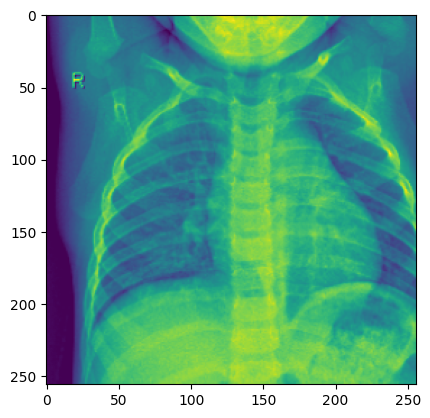

In [41]:
image, label = next(train_data)
im = image

plt.imshow(im[0])

## Building Model

In [42]:
import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Rescaling

In [48]:
model = Sequential()

In [49]:
model.add(Conv2D(8, (3,3), 1, activation='relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation ='relu'))
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy', 'AUC'])

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 8)       80        
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 127, 127, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 32)      

In [52]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [53]:
early = EarlyStopping(monitor = 'val_loss', mode='min', patience=4)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [early, learning_rate_reduction]

In [54]:
unique_classes = np.unique(train_data.classes)
classes = train_data.classes

weights = compute_class_weight(class_weight = 'balanced', classes= unique_classes, y = classes)

class_weights = dict(zip( np.unique(train_data.classes), weights))

class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Training Model

In [ ]:
hist = model.fit(train_data, epochs=20, validation_data = val_data, class_weight = class_weights, callbacks=callbacks_list)

Epoch 1/20
104/163 [==================>...........] - ETA: 1:36 - loss: 1.9468 - accuracy: 0.6211 - auc: 0.5883

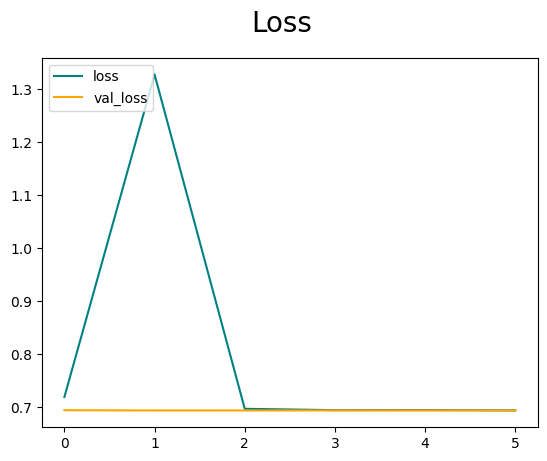

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Testing and Evaluating Model

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import sklearn.metrics

In [31]:
from PIL import Image
img = Image.open('chest_xray_shuffled/train_shuffled/NORMAL/IM-0117-0001.jpeg')

img.resize((256,256)

pic = np.asarray(img)

pic.shape



SyntaxError: invalid syntax (944426953.py, line 6)

In [16]:
results = model.evaluate(test_data, batch_size=32)

20/20 [==============================] - 11s 431ms/step - loss: 0.6957 - accuracy: 0.3750 - auc: 0.4240


In [24]:
ypred = model.predict(test_data, batch_size=32)

20/20 [==============================] - 7s 331ms/step


In [25]:
yhat = np.zeros(len(ypred))

for i, item in enumerate(ypred):
    yhat[i] = item
    
    if yhat[i] > 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0

In [26]:
print(yhat)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.

In [27]:
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd

cm = pd.DataFrame(data=confusion_matrix(test_data.classes, yhat, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])

<Axes: >

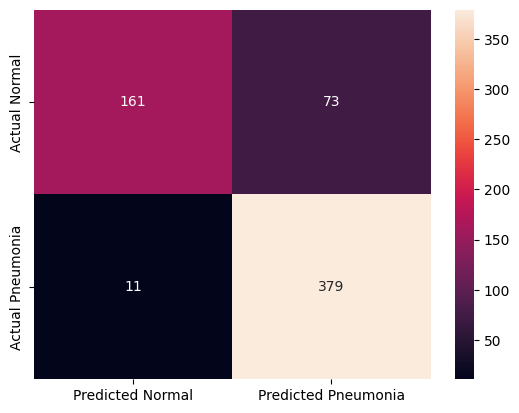

In [28]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [29]:
print(classification_report(y_true=test_data.classes,y_pred=yhat,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.94      0.69      0.79       234
   PNEUMONIA       0.84      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



In [28]:
model.save('new_model.h5')